# Predicting Car Prices

In this project, I will work with a data set containing information on various cars, including technical specs of each vehicle including mpg, acceleration time, and more. The data set can be found here: https://archive.ics.uci.edu/ml/datasets/automobile.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


In [2]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cardata = pd.read_csv('imports-85.data', names = cols)
print(cardata.head())
print(cardata.info())

   symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...  engine-size  \
0  convertible          rwd           front        88.6  ...          130   
1  convertible          rwd           front        88.6  ...          130   
2    hatchback          rwd           front        94.5  ...          152   
3        sedan          fwd           front        99.8  ...          109   
4        sedan          4wd           front        99.4  ...          136   

   fuel-system  bore  stroke compression-rate hors

## Data Cleaning

I will begin cleaning the data by first removing columns that are not or can not be converted to numeric types for analysis.

In [3]:
numeric_cols = ['normalized-losses','wheel-base','length','width','height','curb-weight','engine-size','bore','stroke','compression-rate','horsepower','peak-rpm','city-mpg','highway-mpg','price']
cardata = cardata[numeric_cols]
cardata.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


I can see that there are missing values, indicated by the '?' character in the 'normalized-losses' columnn. I will replace these with a NaN value and convert all values to float types and check for null values. 

In [4]:
cardata = cardata.replace('?',np.nan)
cardata = cardata.astype('float')
cardata.isnull().sum()


normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

First, I will remove the 4 rows which contain missing values for the 'price' column as this is our target column and we want to be able to validate our model with these values. 

In [5]:
cardata = cardata.dropna(subset=['price'])
cardata.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

The 'normalized-losses' column contains 41 missing values. I will now use the average values from each column to fill in these missing values as not to lose the rows entirely because 37/205 rows missing would have a significant impact on our model.

In [6]:
cardata = cardata.fillna(cardata.mean())
cardata.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In order to capture the variability of each column of data without the impact of magnitude of their values, I will normalize each columns values between 0 and 1 except the target column 'price'

In [7]:
price = cardata['price']
cardata = (cardata-cardata.min())/(cardata.max()-cardata.min())
cardata['price'] = price
cardata.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


## Univariate Model

I will start with a simple univariate k nearest neighbor model and then move on to more complex ones. This model will find the best fit model using a single column of training data and will test out different hyperparameter values of k for each case to find the models with the best fit. 

In [8]:
# This function will accept two dataframe columns or series objects and a dataframe. 
# One column will be the training feature
# The second column will be the target feature. 
# This function will perform a holdout univariate validation for each feature with different k values

def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(cardata.index)
    random_cardata = cardata.reindex(shuffled_index)
    
    last_train_row = int(len(random_cardata)/2)
    
    train_cardata = random_cardata.iloc[0:last_train_row]
    test_cardata = random_cardata.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(train_cardata[[train_col]],train_cardata[target_col])
        labels = knn.predict(test_cardata[[train_col]])
        
        mse = mean_squared_error(test_cardata[target_col],labels)
        rmse = mse**(1/2)
        
        k_rmses[k] = rmse
    return k_rmses
    
# Here I will train a model for each training feature and add the returned RMSE value to a dictionary

k_rmse_results = {}

train_cols = cardata.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test(col,'price',cardata)
    k_rmse_results[col] = rmse_val

    
k_rmse_results

{'normalized-losses': {1: 7846.750605148984,
  3: 7500.5698123109905,
  5: 7330.197653434445,
  7: 7756.421586234123,
  9: 7688.096096891432},
 'wheel-base': {1: 4493.734068810494,
  3: 5120.161506064513,
  5: 5461.553997873057,
  7: 5448.1070513823315,
  9: 5738.405685192312},
 'length': {1: 4628.45550121557,
  3: 5129.8358210721635,
  5: 5427.2009608367125,
  7: 5313.427720847974,
  9: 5383.054514833446},
 'width': {1: 4559.257297950061,
  3: 4606.413692169901,
  5: 4704.482589704386,
  7: 4571.485046194653,
  9: 4652.914172067787},
 'height': {1: 8904.04645636071,
  3: 8277.609643045525,
  5: 8144.441042663747,
  7: 7679.598124393773,
  9: 7811.03606291223},
 'curb-weight': {1: 5264.290230758878,
  3: 5022.318011757233,
  5: 4401.118254793124,
  7: 4330.608104418053,
  9: 4632.044474454401},
 'engine-size': {1: 3258.4861059962027,
  3: 2840.562805643501,
  5: 3238.4628296477176,
  7: 3563.086774256415,
  9: 3831.8244149840766},
 'bore': {1: 8602.58848450066,
  3: 6984.239489480916,


I will now visualize these results using a line plot for better understanding.

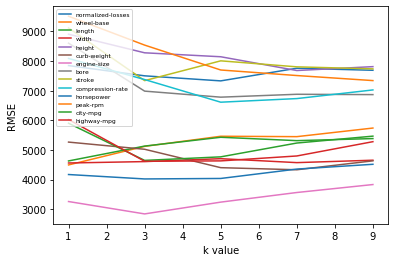

In [9]:

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y,label=k)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    plt.legend(loc=2, prop={'size': 6})
plt.show()

From the plot, I can determine that from all of the univariate models with various hyperparameters, the model which resulted in the lowest rmse value was the model based off of the 'engine-size' feature with a k value of 3. I will now test various multivariate models to see if I can improve the result. 

Before moving on, I will compute the average RMSE across different k values for each feature.

In [10]:
feature_avg_rmse = {}

for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_series_avg_rmse = series_avg_rmse.sort_values()
print(sorted_series_avg_rmse)

sorted_features = sorted_series_avg_rmse.index

engine-size          3346.484586
horsepower           4219.377860
width                4618.910560
curb-weight          4730.075815
highway-mpg          5069.469256
length               5176.394904
city-mpg             5202.409003
wheel-base           5252.392462
compression-rate     7166.073599
bore                 7222.472445
normalized-losses    7624.407151
stroke               8000.240467
peak-rpm             8119.365233
height               8163.346266
dtype: float64


## Multivariate Model

I will now expand this function and model validation method using a K Nearest Neighbors multivariate model where multiple columns are used in the training data to see if I can improve upon my result. 

In [11]:
# This function will accept one list of dataframe columns as the training data
# It will also accept a dataframe column as the target feature. 
# This function will perform a holdout multivariate validation for combination of features with k values ranging from 2-25


def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(cardata.index)
    random_cardata = cardata.reindex(shuffled_index)
    
    last_train_row = int(len(random_cardata)/2)
    
    train_df = random_cardata.iloc[0:last_train_row]
    test_df = random_cardata.iloc[last_train_row:]
    
    k_values = [i for i in range(1,26)]
    k_rmses = {}
    
    for k in k_values:
        
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(train_df[train_cols], train_df[target_col])
    
        labels = knn.predict(test_df[train_cols])
    
        mse = mean_squared_error(test_df[target_col],labels)
        rmse = np.sqrt(mse)
    
        k_rmses[k] = rmse
    
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,7):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(sorted_features[:nr_best_feats],'price',cardata)
k_rmse_results
    
    
    

{'2 best features': {1: 2783.6204237227344,
  2: 2657.7963807419765,
  3: 2792.586573031673,
  4: 2891.5329686923255,
  5: 2949.8817277180374,
  6: 3096.402601694776,
  7: 3164.681969020496,
  8: 3413.228359192009,
  9: 3748.6716603306486,
  10: 4080.7125057341937,
  11: 4215.6372280600335,
  12: 4275.421524277872,
  13: 4373.901683035496,
  14: 4424.285137239815,
  15: 4539.505493095937,
  16: 4667.307671446768,
  17: 4729.605305844226,
  18: 4790.556632159094,
  19: 4824.3866193292615,
  20: 4840.850914693829,
  21: 4837.429062000271,
  22: 4831.16988267597,
  23: 4861.679492959275,
  24: 4903.346008862579,
  25: 4955.892429427362},
 '3 best features': {1: 3399.8148100410203,
  2: 3497.191103423058,
  3: 3333.6966577570593,
  4: 3355.8842294742026,
  5: 3580.7376651928435,
  6: 3732.943016673517,
  7: 3639.9439408462786,
  8: 3747.4209132113137,
  9: 3986.593913133887,
  10: 4005.354888715163,
  11: 4121.687230061635,
  12: 4255.700651624227,
  13: 4328.476829895253,
  14: 4332.21649

Now, I have created models from the training data. There is a multivariate model for each of the range from 2 to 7 best features (which were determined from univariate model validation). For each set of feature models, hyperparameter tuning was also perfomred to acquire model metrics for each k value from 1 to 25. I will plot these models alone to get a visual idea of their performance. 

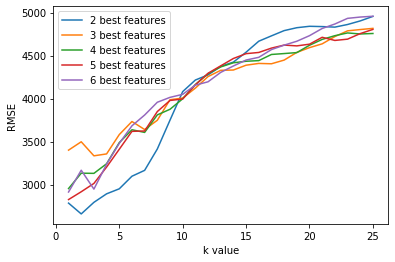

In [12]:
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    plt.plot(x,y,label='{}'.format(k))

plt.xlabel('k value')
plt.ylabel('RMSE')
plt.legend()

## Conclusions

From the plot above, it can be determined that the model with the 2 best features as training data and with a k value of what appears to be 2, we obtained the lowest rmse value. 

Unfortunately, I cannot say that this means that this model will be the most accurate as a model can have two sources of error, bias and variance. The standard deviation of the rmse values can be a proxy for a model's variance, while the average rmse is a proxy for the model's bias. I will explore these concepts in future projects dealing with mathematical models like regression. 